In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import cv2
import supervision as sv
import os

In [2]:
def pixel_accuracy(pred, target):
    correct = (pred == target).sum()
    total = pred.size
    return correct / total

def intersection_over_union(pred, target):
    intersection = (pred & target).sum()
    union = (pred | target).sum()
    return intersection / union

def dice_coefficient(pred, target):
    intersection = (pred & target).sum()
    return 2 * intersection / (pred.sum() + target.sum())



def calculate_metrics(pred_list, target_list):
    total_pixel_acc = 0
    total_iou = 0
    total_dice = 0
    n = len(pred_list)  # Assuming pred_list and target_list are of the same length

    for pred, target in zip(pred_list, target_list):
        total_pixel_acc += pixel_accuracy(pred, target)
        total_iou += intersection_over_union(pred, target)
        total_dice += dice_coefficient(pred, target)

    # Calculate the mean for each metric
    mean_pixel_acc = total_pixel_acc / n
    mean_iou = total_iou / n
    mean_dice = total_dice / n

    return mean_pixel_acc, mean_iou, mean_dice


def get_segmentation_mask_from_image(img, shape=(1920, 1080)):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    masks = img > 0
    return masks
    


In [18]:

import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple

def load_and_process_image(mask_path: str, original_mask_path: str) -> Tuple[np.ndarray, np.ndarray]:
    """Load and preprocess mask images."""
    mask = cv2.imread(mask_path)
    original_mask_img = cv2.imread(original_mask_path)
    
    # Resize logic
    if original_mask_img.shape[:2] != mask.shape[:2]:
        target_shape = (
            min(original_mask_img.shape[1], mask.shape[1]),
            min(original_mask_img.shape[0], mask.shape[0])
        )
        original_mask_img = cv2.resize(original_mask_img, target_shape[::-1])
        mask = cv2.resize(mask, target_shape[::-1])
    
    return mask, original_mask_img

# Define Erosion Function
def apply_erosion(image, kernel_size=(5, 5), iterations=1):
    """
    Apply erosion to an image using a specified kernel size and number of iterations.
    
    Parameters:
    - image: The input image on which erosion will be applied.
    - kernel_size: The size of the kernel to be used for erosion.
    - iterations: The number of times erosion is applied.
    
    Returns:
    - eroded_image: The eroded image.
    ""
    
    """
    est = cv2.getStructuringElement(cv2.MORPH_ERODE, kernel_size)
    eroded_image = cv2.erode(image, est, iterations=iterations)
    return eroded_image


def erode_all_masks(masks: List[np.ndarray], kernel_size=(5, 5), iterations=1) -> List[np.ndarray]:
    """Apply erosion to all masks."""
    return [apply_erosion(mask, kernel_size, iterations) for mask in masks]

def apply_dilation(image, kernel_size=(5, 5), iterations=1):
    """
    Apply dilation to an image using a specified kernel size and number of iterations.
    
    Parameters:
    - image: The input image on which dilation will be applied.
    - kernel_size: The size of the kernel to be used for dilation.
    - iterations: The number of times dilation is applied.
    
    Returns:
    - dilated_image: The dilated image.
    ""
    
    """
    est = cv2.getStructuringElement(cv2.MORPH_DILATE, kernel_size)
    dilated_image = cv2.dilate(image, est, iterations=iterations)
    return dilated_image

def dilate_all_masks(masks: List[np.ndarray], kernel_size=(5, 5), iterations=1) -> List[np.ndarray]:
    """Apply dilation to all masks."""
    return [apply_dilation(mask, kernel_size, iterations) for mask in masks]


def apply_opening(image, kernel_size=(5, 5), iterations=1):
    """
    Apply opening to an image using a specified kernel size and number of iterations.
    
    Parameters:
    - image: The input image on which opening will be applied.
    - kernel_size: The size of the kernel to be used for opening.
    - iterations: The number of times opening is applied.
    
    Returns:
    - opened_image: The opened image.
    ""
    
    """
    est = cv2.getStructuringElement(cv2.MORPH_OPEN, kernel_size)
    opened_image = cv2.morphologyEx(image, cv2.MORPH_OPEN, est, iterations=iterations)
    return opened_image

def open_all_masks(masks: List[np.ndarray], kernel_size=(5, 5), iterations=1) -> List[np.ndarray]:
    """Apply opening to all masks."""
    return [apply_opening(mask, kernel_size, iterations) for mask in masks]

def apply_closing(image, kernel_size=(5, 5), iterations=1):
    """
    Apply closing to an image using a specified kernel size and number of iterations.
    
    Parameters:
    - image: The input image on which closing will be applied.
    - kernel_size: The size of the kernel to be used for closing.
    - iterations: The number of times closing is applied.
    
    Returns:
    - closed_image: The closed image.
    ""
    
    """
    est = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
    closed_image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, est, iterations=iterations)
    return closed_image

def close_all_masks(masks: List[np.ndarray], kernel_size=(5, 5), iterations=1) -> List[np.ndarray]:
    """Apply closing to all masks."""
    return [apply_closing(mask, kernel_size, iterations) for mask in masks]



def plot_mask_operations(mask_file: str, experiment_path: str, masks: List[np.ndarray], mask_files: List[str]):
    
    # Find the index of the mask file
    index = mask_files.index(mask_file)
    # Load original not masked image
    original_image_path = os.path.join(experiment_path, "original", mask_file)
    original_image = cv2.imread(original_image_path)

    # Load the original image
    original_image_path_masked = os.path.join(experiment_path, "masked", mask_file)
    original_image_masked = cv2.imread(original_image_path_masked)
    
    # Get the corresponding mask
    mask = masks[index]
    
    # Plot the original image and apply every defined operation and plot them
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    # Plot original image
    axes[0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    axes[0].set_title(f'Original Image\n{mask_file}')
    axes[0].axis('off')

    # Plot original mask
    axes[1].imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f'Original Mask\n{mask_file}')
    axes[1].axis('off')

    # Apply erosion and plot
    eroded_mask = apply_erosion(mask, kernel_size=(9, 9), iterations=1)
    axes[2].imshow(cv2.cvtColor(eroded_mask, cv2.COLOR_BGR2RGB))
    axes[2].set_title('Eroded Mask')
    axes[2].axis('off')

    # Apply dilation and plot
    dilated_mask = apply_dilation(mask, kernel_size=(9, 9), iterations=1)
    axes[3].imshow(cv2.cvtColor(dilated_mask, cv2.COLOR_BGR2RGB))
    axes[3].set_title('Dilated Mask')
    axes[3].axis('off')

    # Apply opening and plot
    opened_mask = apply_opening(mask, kernel_size=(9, 9), iterations=1)
    axes[4].imshow(cv2.cvtColor(opened_mask, cv2.COLOR_BGR2RGB))
    axes[4].set_title('Opened Mask')
    axes[4].axis('off')

    # Apply closing and plot
    closed_mask = apply_closing(mask, kernel_size=(9, 9), iterations=1)
    axes[5].imshow(cv2.cvtColor(closed_mask, cv2.COLOR_BGR2RGB))
    axes[5].set_title('Closed Mask')
    axes[5].axis('off')

    plt.tight_layout()
    plt.show()



In [ ]:

# Set paths
sessoes_folder = "./sessoes"
original_mask_folder = 'pad_segmentation_all/all-mask'

#get masked images from "sessoe/group_1-manual-lapsal-group_1-Vinicius_Moraes"
experiment_path = "sessoes/sam-336e2l-group_2-João_Felipe_Gobeti_Calenzani"
mask_path = os.path.join(experiment_path, "masked")
original_mask_path = "pad_segmentation_all/all-mask"


sample_files = os.listdir(mask_path)

#load images
masks = []
mask_files = []
original_masks = []
for file in sample_files:
    mask = cv2.imread(os.path.join(mask_path, file))
    original_mask = cv2.imread(os.path.join(original_mask_path, (file[:-4] + "_segmentation.png")))
    masks.append(mask)
    mask_files.append(file)
    original_masks.append(original_mask)



#for every eroded mask, check if size is equal to original mask, resize both to the minimum size
for i in range(len(masks)):
    if original_masks[i].shape[:2] != masks[i].shape[:2]:
        target_shape = (
            min(original_masks[i].shape[1], masks[i].shape[1]),
            min(original_masks[i].shape[0], masks[i].shape[0])
        )
        original_masks[i] = cv2.resize(original_masks[i], target_shape[::-1])
        masks[i] = cv2.resize(masks[i], target_shape[::-1])



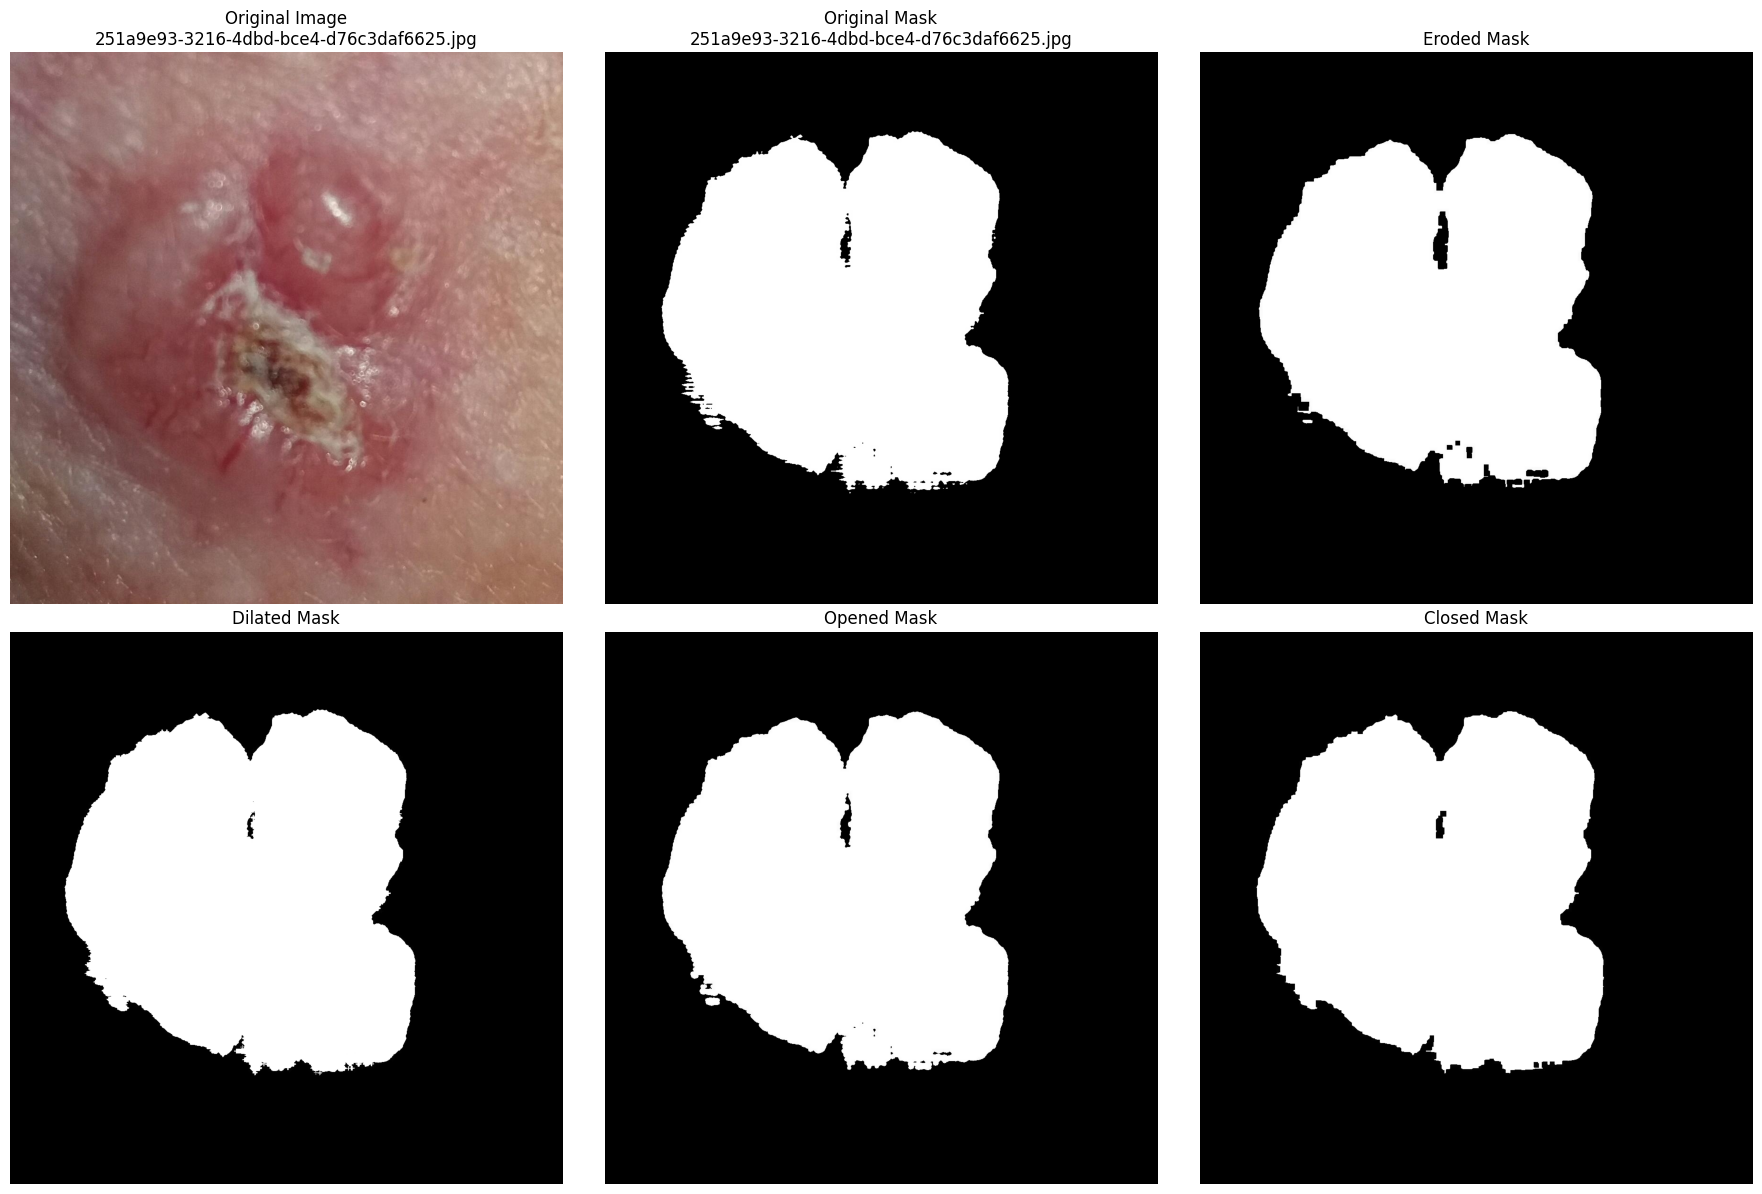

In [19]:
plot_mask_operations(mask_files[0], experiment_path=experiment_path, masks=masks, mask_files=mask_files)


In [7]:

def collect_metrics(sessoes_folder: str, original_mask_folder: str) -> Tuple[pd.DataFrame, Dict]:
    """Collect metrics for all images and organize them into a DataFrame."""
    # Initialize data storage
    data_rows = []
    groups_data = {
        "sam": {f"group_{i}": {"metrics": [], "time": []} for i in range(1, 5)},
        "manual": {f"group_{i}": {"metrics": [], "time": []} for i in range(1, 5)}
    }
    
    print(f"Processing folders:")
    print(f"Total folders: {len(os.listdir(sessoes_folder))}")
    print(f"SAM folders: {len([f for f in os.listdir(sessoes_folder) if 'sam' in f])}")
    print(f"Manual folders: {len([f for f in os.listdir(sessoes_folder) if 'manual' in f])}\n")

    for sessao in os.listdir(sessoes_folder):
        # Get group name
        group_name = next((g for g in ["group_1", "group_2", "group_3", "group_4"] if g in sessao), None)
        if not group_name:
            continue
            
        # Skip small sessions
        masked_path = os.path.join(sessoes_folder, sessao, "masked")
        if len(os.listdir(masked_path)) < 50:
            print(f"Skipping {sessao} - insufficient images")
            continue
            
        # Get processing type (sam or manual)
        proc_type = "sam" if "sam" in sessao else "manual"
        
        # Process each image
        for image in os.listdir(masked_path):
            original_mask_name = image.replace('.jpg', '_segmentation.png')
            original_mask_path = os.path.join(original_mask_folder, original_mask_name)
            
            if not os.path.exists(original_mask_path):
                continue
                
            # Process images
            mask, original_mask = load_and_process_image(
                os.path.join(masked_path, image),
                original_mask_path
            )
            
            # Apply morphological operations
            eroded_mask = apply_erosion(mask, kernel_size=(5, 5), iterations=1)
            dilated_mask = apply_dilation(mask, kernel_size=(5, 5), iterations=1)
            opened_mask = apply_opening(mask, kernel_size=(5, 5), iterations=1)
            closed_mask = apply_closing(mask, kernel_size=(5, 5), iterations=1)
            
            # Calculate metrics for each version
            for version, processed_mask in zip(
                ["original", "eroded", "dilated", "opened", "closed"],
                [mask, eroded_mask, dilated_mask, opened_mask, closed_mask]
            ):
                pixel_acc, iou, dice = calculate_metrics([processed_mask], [original_mask])
                
                # Get processing time
                with open(os.path.join(sessoes_folder, sessao, "time.txt"), "r") as f:
                    time = float(f.readlines()[0])
                
                # Store data
                data_rows.append({
                    "group": group_name,
                    "type": proc_type,
                    "version": version,
                    "pixel_accuracy": pixel_acc,
                    "iou": iou,
                    "dice": dice,
                    "time": time
                })
                
                # Store group-specific data
                groups_data[proc_type][group_name]["metrics"].append([pixel_acc, iou, dice])
                groups_data[proc_type][group_name]["time"].append(time)
    
    return pd.DataFrame(data_rows), groups_data

In [20]:
#This operation takes time and the results are stored in a csv file
# # Set paths
# sessoes_folder = "./sessoes"
# original_mask_folder = 'pad_segmentation_all/all-mask'

# # Collect metrics
# metrics_df, groups_data = collect_metrics(sessoes_folder, original_mask_folder)



In [11]:
#save   
# metrics_df.to_csv('metrics_df.csv', index=False)
#read 
metrics_df = pd.read_csv('metrics_df.csv')
metrics_df.head()

,group,type,version,pixel_accuracy,iou,dice,time
0,group_2,manual,original,0.884036,0.766283,0.867679,604.131
1,group_2,manual,eroded,0.866008,0.744922,0.853817,604.131
2,group_2,manual,dilated,0.892960,0.781096,0.877096,604.131
3,group_2,manual,opened,0.877416,0.765911,0.867440,604.131
4,group_2,manual,closed,0.887952,0.766541,0.867844,604.131


In [22]:
# Group by 'group', 'type', and 'version' and aggregate the metrics
aggregated_metrics = metrics_df.groupby(['group', 'type', 'version']).agg({
    'iou': ['mean', 'std'],
    'dice': ['mean', 'std'],
    'time': ['mean', 'std']
}).reset_index()

# Rename columns for better readability
aggregated_metrics.columns = [
    'group', 'type', 'version',
    'iou_mean', 'iou_std',
    'dice_mean', 'dice_std',
    'time_mean', 'time_std'
]

aggregated_metrics.head()

,group,type,version,iou_mean,iou_std,dice_mean,dice_std,time_mean,time_std
0,group_1,manual,closed,0.719992,0.161127,0.825549,0.125885,504.460182,232.517458
1,group_1,manual,dilated,0.704776,0.164807,0.814399,0.130044,504.460182,232.517458
2,group_1,manual,eroded,0.735761,0.154357,0.837268,0.119515,504.460182,232.517458
3,group_1,manual,opened,0.720729,0.160882,0.826094,0.125635,504.460182,232.517458
4,group_1,manual,original,0.720303,0.161018,0.825780,0.125778,504.460182,232.517458


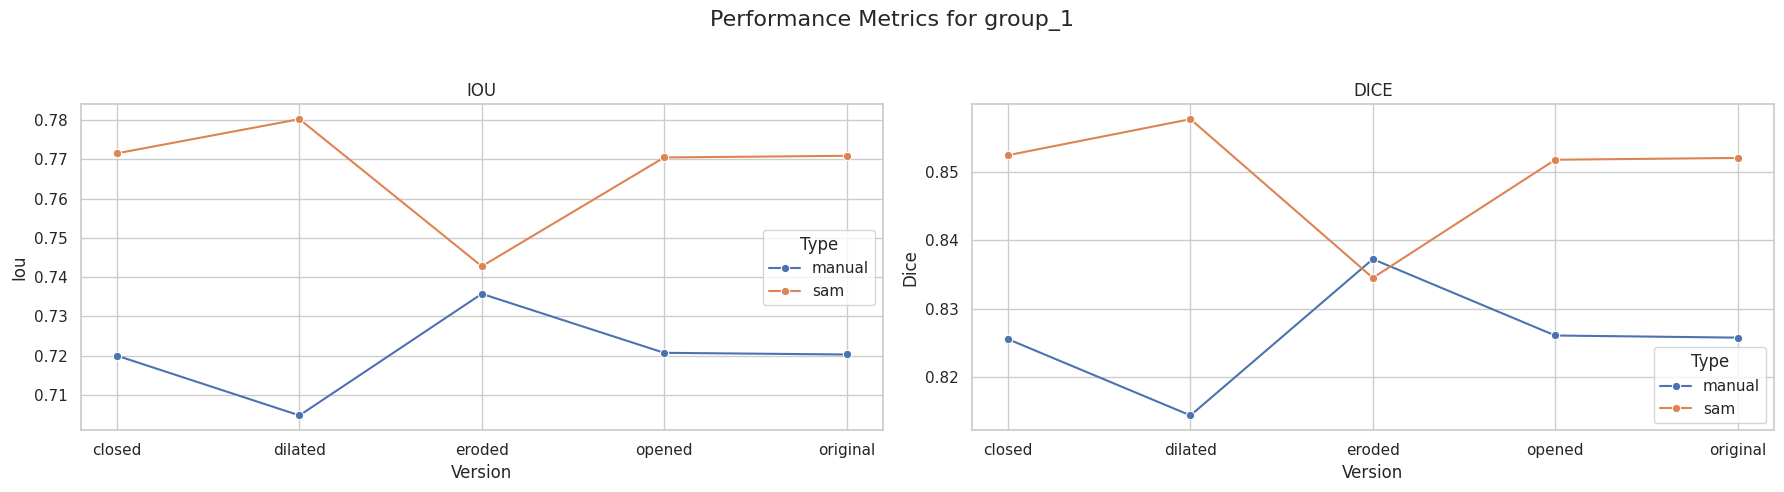

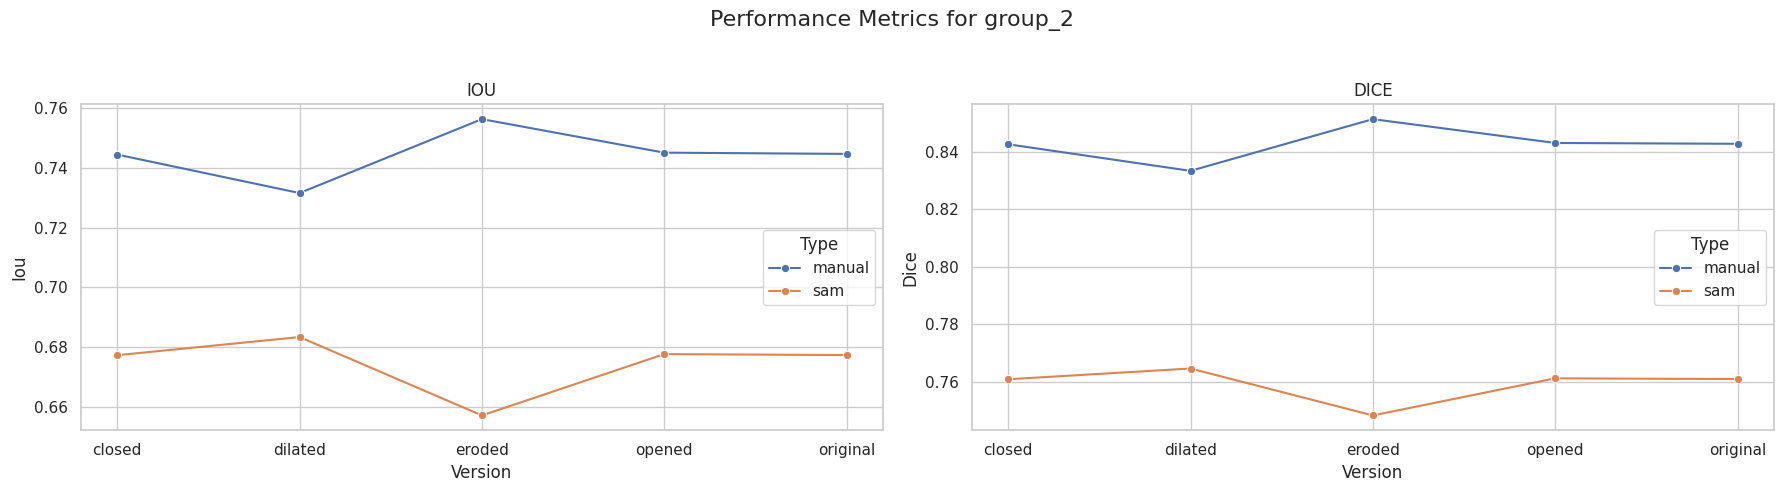

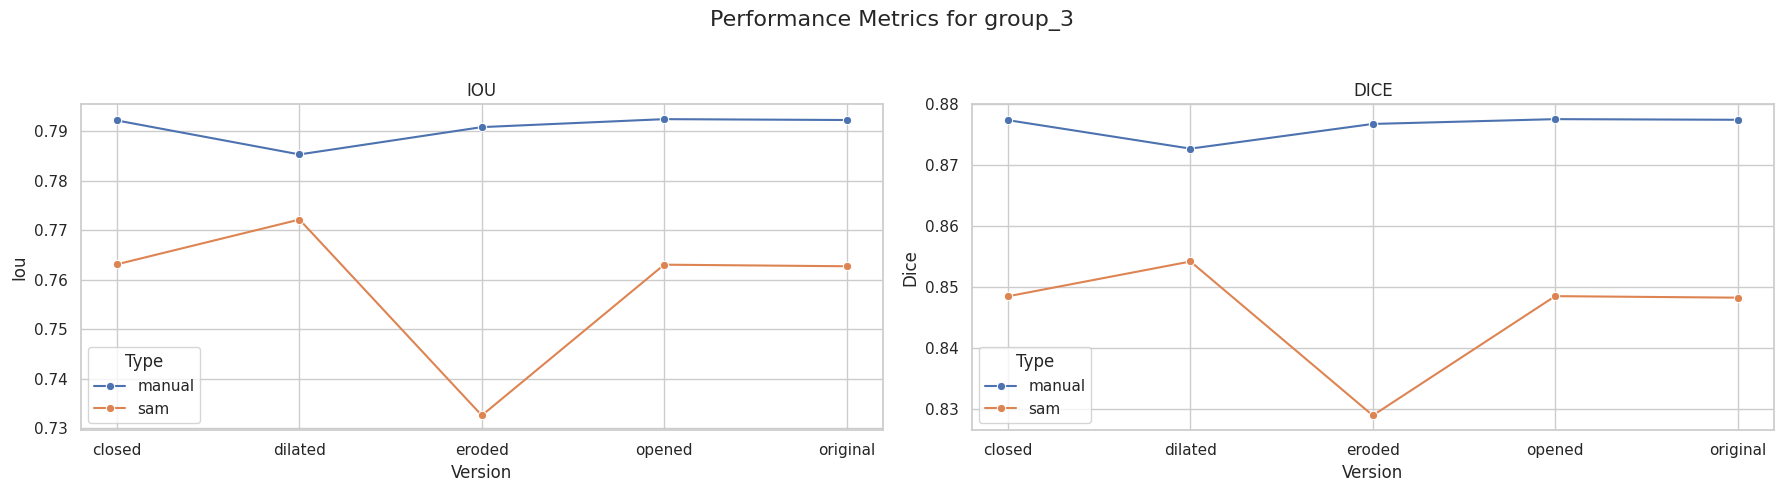

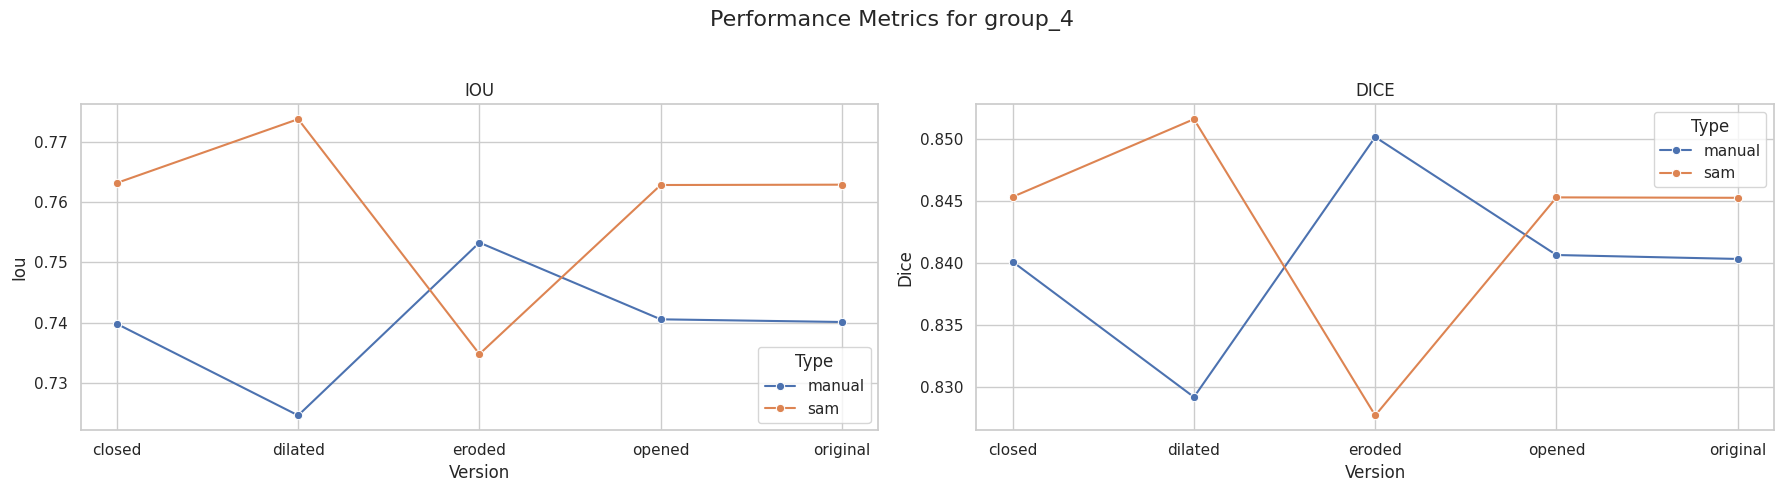

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the visualization
sns.set_theme(style="whitegrid")

# Create a function to plot the metrics for each group
def plot_metrics(aggregated_metrics):
    groups = aggregated_metrics['group'].unique()
    metrics = ['iou_mean', 'dice_mean']
    
    for group in groups:
        group_data = aggregated_metrics[aggregated_metrics['group'] == group]
        
        fig, axes = plt.subplots(1, 2, figsize=(18, 5), sharey=False)
        fig.suptitle(f'Performance Metrics for {group}', fontsize=16)
        
        for i, metric in enumerate(metrics):
            sns.lineplot(
                x='version', y=metric, hue='type', data=group_data, ax=axes[i], marker='o'
            )
            axes[i].set_title(metric.replace('_mean', '').upper())
            axes[i].set_xlabel('Version')
            axes[i].set_ylabel(metric.replace('_mean', '').capitalize())
            axes[i].legend(title='Type')
        
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

# Plot the metrics for each group
plot_metrics(aggregated_metrics)

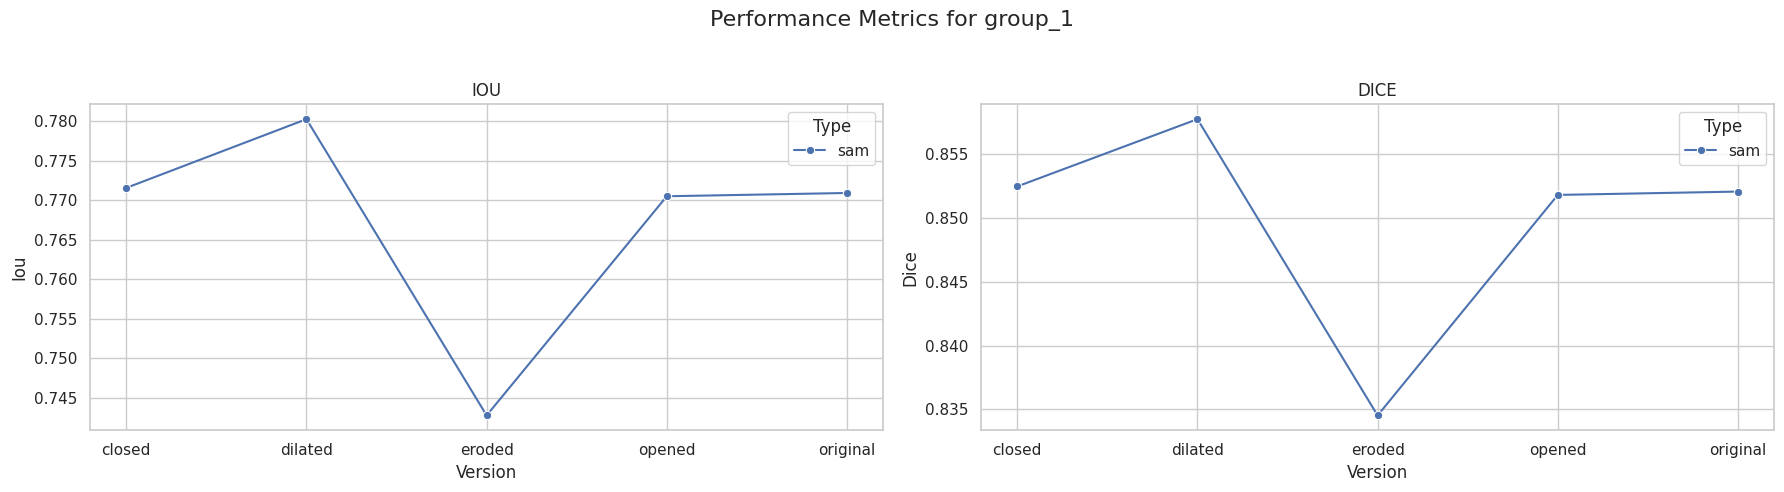

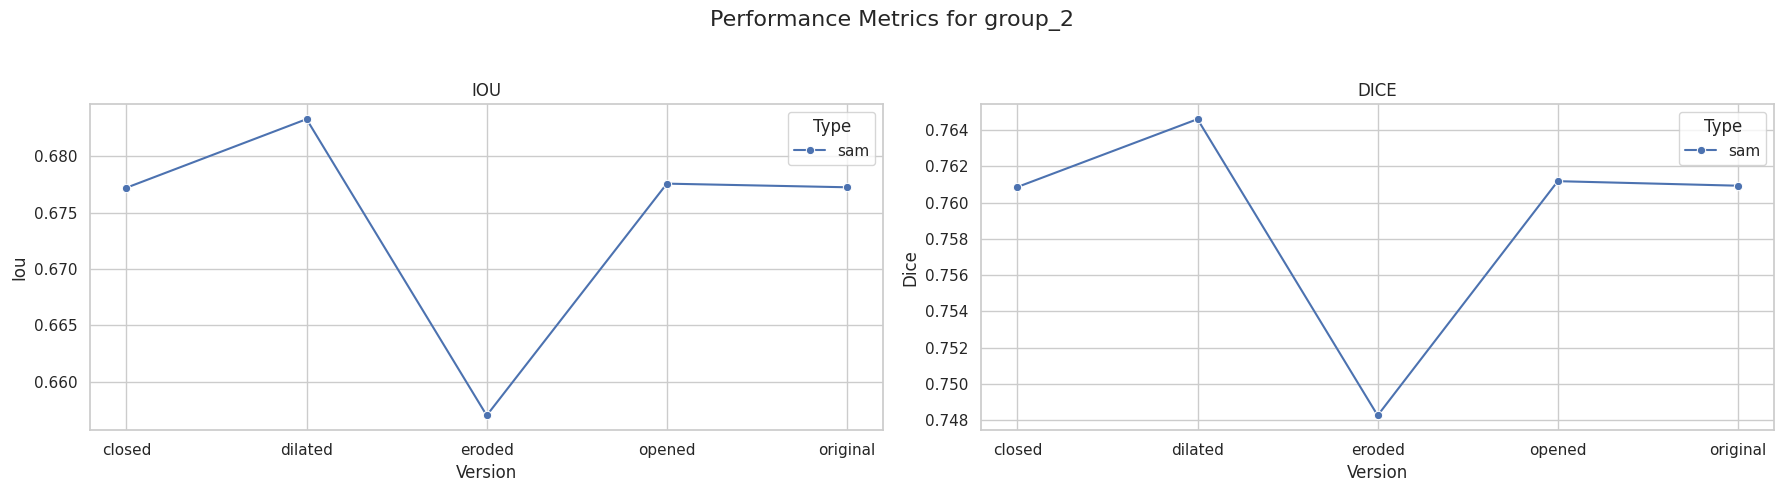

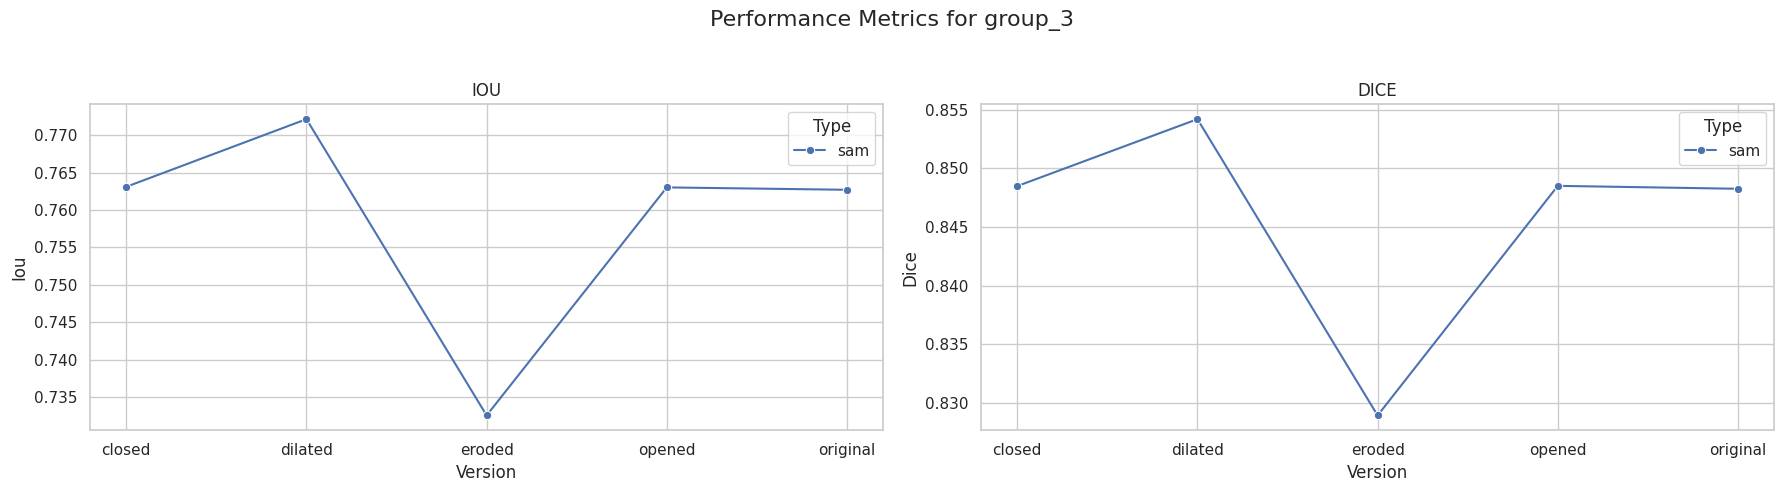

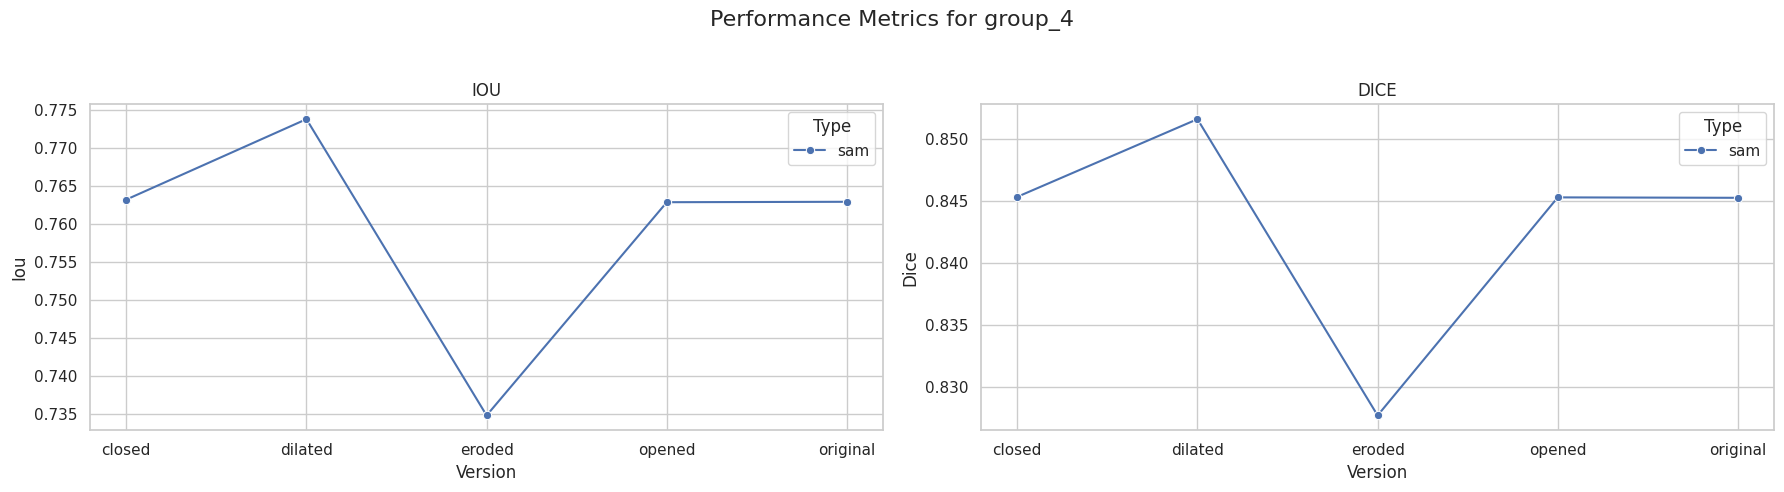

In [38]:
#plot metrics but only for the sam
sam_metrics = aggregated_metrics[aggregated_metrics['type'] == 'sam']
plot_metrics(sam_metrics)


In [40]:
# Aggregate data by 'type' and 'version' and calculate the mean for Dice and IoU
aggregated_means = metrics_df.groupby(['type', 'version']).agg({
    'iou': 'mean',
    'dice': 'mean'
}).reset_index()

# Rename columns for better readability
aggregated_means.columns = ['type', 'version', 'iou_mean', 'dice_mean']

# Print the aggregated means
print(aggregated_means)

     type   version  iou_mean  dice_mean
0  manual    closed  0.751204   0.847970
1  manual   dilated  0.738885   0.839158
2  manual    eroded  0.760660   0.855083
3  manual    opened  0.751791   0.848388
4  manual  original  0.751434   0.848139
5     sam    closed  0.744379   0.827513
6     sam   dilated  0.753037   0.832794
7     sam    eroded  0.717257   0.810491
8     sam    opened  0.744121   0.827438
9     sam  original  0.744060   0.827357


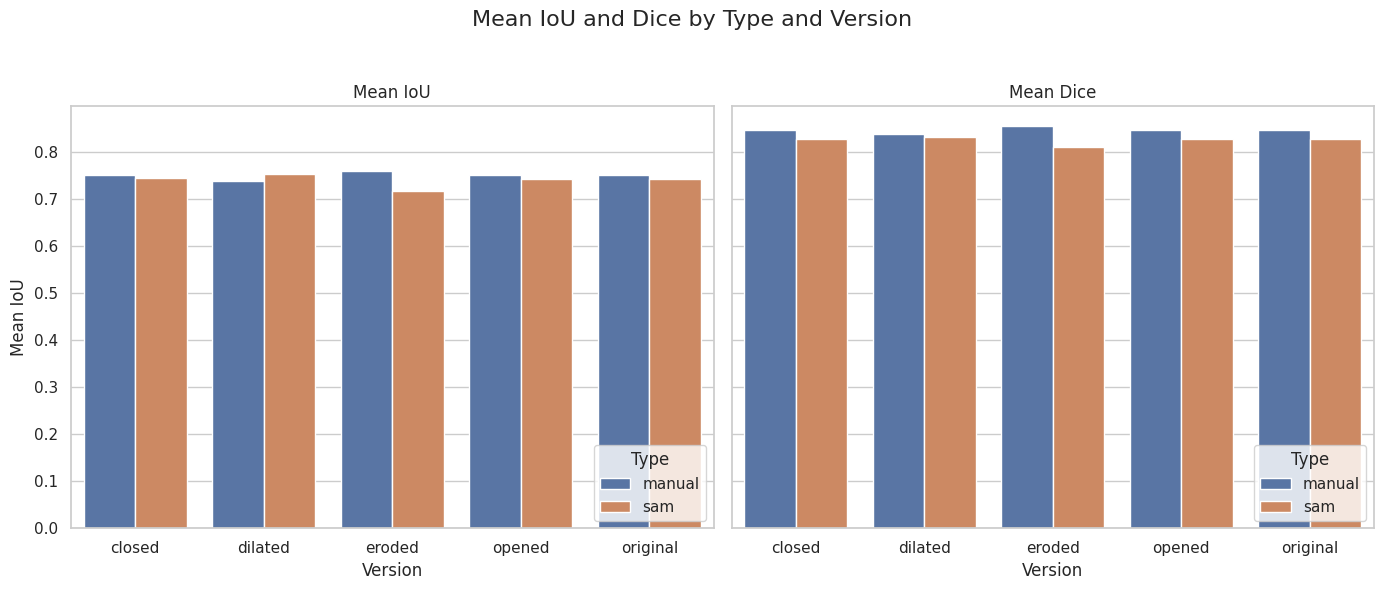

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the visualization
sns.set_theme(style="whitegrid")

# Plot the aggregated means
def plot_aggregated_means(aggregated_means):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    fig.suptitle('Mean IoU and Dice by Type and Version', fontsize=16)
    
    sns.barplot(
        x='version', y='iou_mean', hue='type', data=aggregated_means, ax=axes[0]
    )
    axes[0].set_title('Mean IoU')
    axes[0].set_xlabel('Version')
    axes[0].set_ylabel('Mean IoU')
    axes[0].legend(title='Type', loc='lower right')
    
   
    sns.barplot(
        x='version', y='dice_mean', hue='type', data=aggregated_means, ax=axes[1]
    )
    axes[1].set_title('Mean Dice')
    axes[1].set_xlabel('Version')
    axes[1].set_ylabel('Mean Dice')
    axes[1].legend(title='Type', loc='lower right')
    
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Plot the aggregated means
plot_aggregated_means(aggregated_means)

Erosion improves the manual masks whereas dilation improve sam masks metrics. 